In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image  # Add this import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from math import ceil

In [ ]:
import os
import shutil
import random

# Original dataset path
SOURCE_DIR = r"C:\Users\kaviy\OneDrive\Documents\paper code\archive (1)"
TRAIN_DIR = os.path.join(SOURCE_DIR, "train")
TEST_DIR = os.path.join(SOURCE_DIR, "test")

# Create train/test folders
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Loop through each class folder and split
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if os.path.isdir(class_path) and class_name not in ['train', 'test']:
        images = os.listdir(class_path)
        random.shuffle(images)
        split_index = int(len(images) * 0.8)
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Create class folders
        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)

        # Copy files
        for img in train_images:
            shutil.copy(os.path.join(class_path, img),
                        os.path.join(TRAIN_DIR, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img),
                        os.path.join(TEST_DIR, class_name, img))

print("✅ Dataset split into training and testing folders.")

In [3]:
# Set the directories for the trr"C:\Users\kaviy
#aining and test images
TRAIN_DIR = r"C:\Users\kaviy\OneDrive\Documents\paper code\archive (1)\OriginalDataset\train"
TEST_DIR = r"C:\Users\kaviy\OneDrive\Documents\paper code\archive (1)\OriginalDataset\test"

In [4]:
# Set the image size and batch size
IMAGE_SIZE = 176
BATCH_SIZE = 10

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

In [6]:
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

In [7]:
# Function to load images from a folder
def load_images_from_folder(folder, klass, num_images=4):
    images = []
    for filename in os.listdir(os.path.join(folder, klass))[:num_images]:
        img_path = os.path.join(folder, klass, filename)
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='grayscale')
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
    return np.vstack(images)

In [8]:
num_images_to_display = 8  # or any other number that you prefer

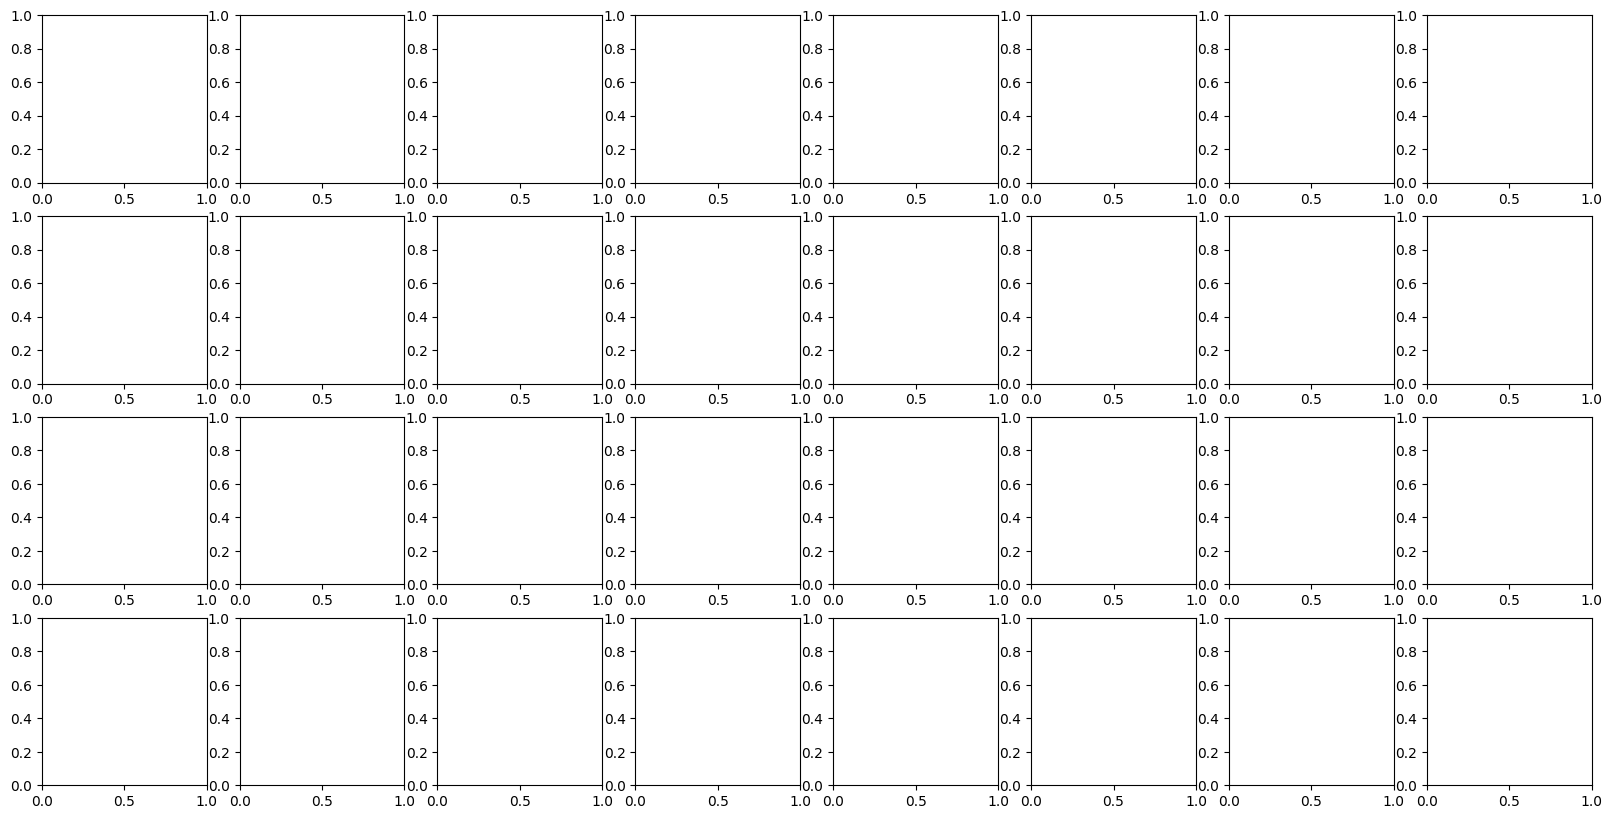

In [9]:
# Create a subplot grid

fig, axes = plt.subplots(nrows=len(CLASSES), ncols=num_images_to_display, figsize=(20, 10))

In [11]:
import os
import numpy as np
from PIL import Image

def load_images_from_folder(folder, class_name, limit=None):
    images = []
    class_path = os.path.join(folder, class_name)
    image_files = os.listdir(class_path)

    if limit:
        image_files = image_files[:limit]

    for filename in image_files:
        img_path = os.path.join(class_path, filename)
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    return np.array(images)

In [12]:
# Set class names as titles for the first column
for ax, klass in zip(axes[:, 0], CLASSES):
    ax.set_ylabel(klass, rotation=90, size='large')

In [13]:
# Set class names as titles for the first column
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [15]:
# Build the CNN model
model_cnn = build_model()


c:\Users\kaviy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile the model
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [17]:
# Create data generators
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical')

Found 5119 images belonging to 4 classes.


In [18]:
validation_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)


Found 1281 images belonging to 4 classes.


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',     # You can also use 'val_accuracy'
    patience=5,             # Stop if no improvement after 5 epochs
    restore_best_weights=True
)

# Train the model with early stopping
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // BATCH_SIZE),
    callbacks=[early_stop]  # Add this line
)

Epoch 1/50


c:\Users\kaviy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


511/511 ━━━━━━━━━━━━━━━━━━━━ 60s 115ms/step - accuracy: 0.4799 - loss: 1.1044 - val_accuracy: 0.5750 - val_loss: 0.9001
Epoch 2/50
  1/511 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - accuracy: 0.5000 - loss: 0.9038

c:\Users\kaviy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5000 - loss: 0.9038 - val_accuracy: 0.5852 - val_loss: 0.8934
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.5726 - loss: 0.8893 - val_accuracy: 0.6742 - val_loss: 0.7127
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7000 - loss: 0.6333 - val_accuracy: 0.6695 - val_loss: 0.7122
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.6719 - loss: 0.7049 - val_accuracy: 0.8008 - val_loss: 0.4877
Epoch 6/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5000 - loss: 0.8196 - val_accuracy: 0.8086 - val_loss: 0.4749
Epoch 7/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 446s 875ms/step - accuracy: 0.7749 - loss: 0.5031 - val_accuracy: 0.8656 - val_loss: 0.3459
Epoch 8/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9000 - loss: 0.2087 - val_accuracy: 0.8711 - val_loss: 0.3393
Epoch 9/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 96s 188ms/step - accuracy: 0.8410 - loss: 0.3624 - val_accuracy:

In [20]:
# Save the model
model_cnn.save('cnn_model.h5')


In [21]:
# Evaluate the model on the test set
evaluate_cnn = model_cnn.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE, verbose=1)
print('CNN Model Loss: {}, CNN Model Accuracy: {}'.format(evaluate_cnn[0], evaluate_cnn[1]))


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9548 - loss: 0.1271
CNN Model Loss: 0.0907214805483818, CNN Model Accuracy: 0.96484375


In [22]:
# Predict the test set
validation_generator.reset()
predictions_cnn = model_cnn.predict(validation_generator, steps=len(validation_generator))


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


In [23]:
# Convert predictions to class indices
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)


In [24]:
# Get the true class indices
true_classes_cnn = validation_generator.classes

In [25]:
# Get the confusion matrix
cm_cnn = confusion_matrix(true_classes_cnn, predicted_classes_cnn)
print(cm_cnn)

[[174   0   3   3]
 [ 12   0   0   1]
 [  1   0 627  12]
 [  5   0   8 435]]


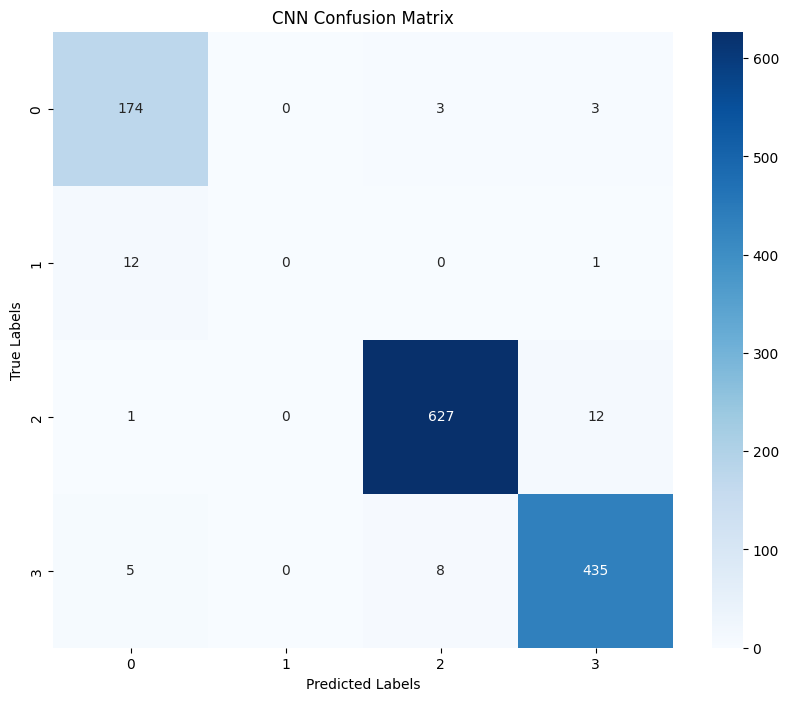

In [26]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

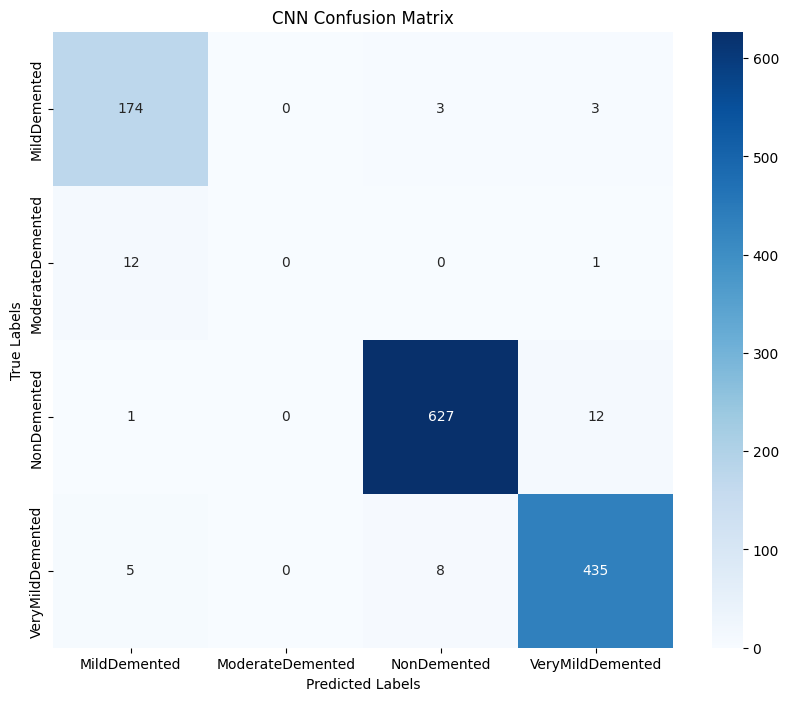

In [27]:
# Generate and plot the confusion matrix for CNN
confusion_mtx_cnn = confusion_matrix(true_classes_cnn, predicted_classes_cnn)
plt.figure(figsize=(10, 8))
class_labels_cnn = list(validation_generator.class_indices.keys())
sns.heatmap(confusion_mtx_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_cnn, yticklabels=class_labels_cnn)
plt.title('CNN Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ✅ Correct IMAGE_SIZE definition as an integer
IMAGE_SIZE = 128  # NOT (128, 128)

def build_advanced_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))  # 1 for grayscale images
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))  # Assuming 4 output classes
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    return model

# To build the model safely
model_advanced_cnn = build_advanced_model()
model_advanced_cnn.summary()

c:\Users\kaviy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,524 (6.48 MB)

 Trainable params: 1,699,076 (6.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
model_advanced_cnn.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

In [30]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [31]:
# Data generator for validation data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
# Train generator
train_generator_advanced = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical'
)


Found 5119 images belonging to 4 classes.


In [33]:
validation_generator_advanced = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False  # Important for consistent evaluation
)

Found 1281 images belonging to 4 classes.


In [34]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator_advanced.classes),
    y=train_generator_advanced.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


In [35]:
# Callbacks for advanced CNN model
callbacks_advanced = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('best_advanced_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [ ]:
# Train the advanced CNN model with class weights
history_advanced_cnn = model_advanced_cnn.fit(
    train_generator_advanced,
    steps_per_epoch=train_generator_advanced.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator_advanced,
    validation_steps=validation_generator_advanced.samples // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks_advanced
)


In [ ]:
 #Evaluate the advanced CNN model on the test set
evaluate_advanced_cnn = model_advanced_cnn.evaluate(
    validation_generator_advanced,
    steps=validation_generator_advanced.samples // BATCH_SIZE,
    verbose=1
)
print('Advanced CNN Model Loss: {}, Advanced CNN Model Accuracy: {}'.format(evaluate_advanced_cnn[0], evaluate_advanced_cnn[1]))


In [ ]:
# Plot training history for advanced CNN model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_advanced_cnn.history['loss'], label='Training Loss')
plt.plot(history_advanced_cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Advanced CNN)')

plt.subplot(1, 2, 2)
plt.plot(history_advanced_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_advanced_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Advanced CNN)')

plt.show()


In [ ]:
# Correctly calculate the number of steps to cover all samples in the validation set
validation_steps_advanced = ceil(validation_generator_advanced.samples / BATCH_SIZE)

In [ ]:
# Reset the validation generator to ensure the order of the samples
validation_generator_advanced.reset()

In [ ]:
# Predict the validation set results for advanced CNN
predictions_advanced = model_advanced_cnn.predict(validation_generator_advanced, steps=validation_steps_advanced)


In [ ]:
# Convert predictions to class indices
predicted_classes_advanced = np.argmax(predictions_advanced, axis=1)

# Ensure that true_classes and predicted_classes have the same length
true_classes_advanced = validation_generator_advanced.classes[:len(predicted_classes_advanced)]

In [ ]:
# Generate and plot the confusion matrix for advanced CNN
confusion_mtx_advanced = confusion_matrix(true_classes_advanced, predicted_classes_advanced)
plt.figure(figsize=(10, 8))
class_labels_advanced = list(validation_generator_advanced.class_indices.keys())
sns.heatmap(confusion_mtx_advanced, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_advanced, yticklabels=class_labels_advanced)
plt.title('Advanced CNN Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
# Define class labels
class_labels_advanced = list(validation_generator_advanced.class_indices.keys())

# ...

# Plot the confusion matrix for Advanced CNN with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_advanced, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_advanced, yticklabels=class_labels_advanced)
plt.title('Advanced CNN Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [1]:
from tensorflow.keras.models import load_model

model = load_model("cnn_model.h5")

In [17]:
print(model.input_shape)
print(img_array.shape)

(None, 176, 176, 1)
(1, 176, 176, 1)


In [ ]:
from PIL import Image

try:
    test_img = Image.open(img_path)
    test_img.show()  # Optional: Opens the image
    print("Image loaded successfully ✅")
except Exception as e:
    print(" Error loading image:", e)

Image loaded successfully ✅


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"C:\Users\kaviy\Downloads\download.jpg"  # ✅ Put your actual image here  # ✅ Put your actual image here

# Load and preprocess
img = image.load_img(img_path, target_size=(176, 176),color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
class_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
predicted_class = np.argmax(pred)

print("Predicted Class:", class_labels[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Class: NonDemented
